In [1]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Forecasting
from prophet import Prophet

# Metrics
from sklearn.metrics import mean_absolute_error


In [2]:
df = pd.read_csv("Sample - Superstore.csv", encoding="latin1")


In [3]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")


In [4]:
df['order_date'] = pd.to_datetime(df['order_date'])

df = df[df['sales'] > 0]   # remove zero/negative sales


In [5]:
monthly_sales = (
    df
    .groupby(pd.Grouper(key='order_date', freq='M'))['sales']
    .sum()
    .reset_index()
)


C:\Users\shravya\AppData\Local\Temp\ipykernel_13796\1281576058.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(key='order_date', freq='M'))['sales']


In [6]:
prophet_df = monthly_sales.rename(columns={
    'order_date': 'ds',
    'sales': 'y'
})


In [7]:
prophet_df['month'] = prophet_df['ds'].dt.month
prophet_df['year'] = prophet_df['ds'].dt.year


In [8]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model.fit(prophet_df)


12:45:11 - cmdstanpy - INFO - Chain [1] start processing
12:45:14 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)


C:\Users\shravya\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [10]:
forecast_output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


In [11]:
merged = pd.merge(
    prophet_df,
    forecast_output,
    on='ds',
    how='left'
)


In [12]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

smape_value = smape(merged['y'], merged['yhat'])
smape_value


np.float64(13.16226443875351)

In [13]:
powerbi_df = merged.rename(columns={
    'ds': 'date',
    'y': 'actual_sales',
    'yhat': 'forecast_sales'
})

powerbi_df.to_csv("retail_sales_forecast_powerbi.csv", index=False)


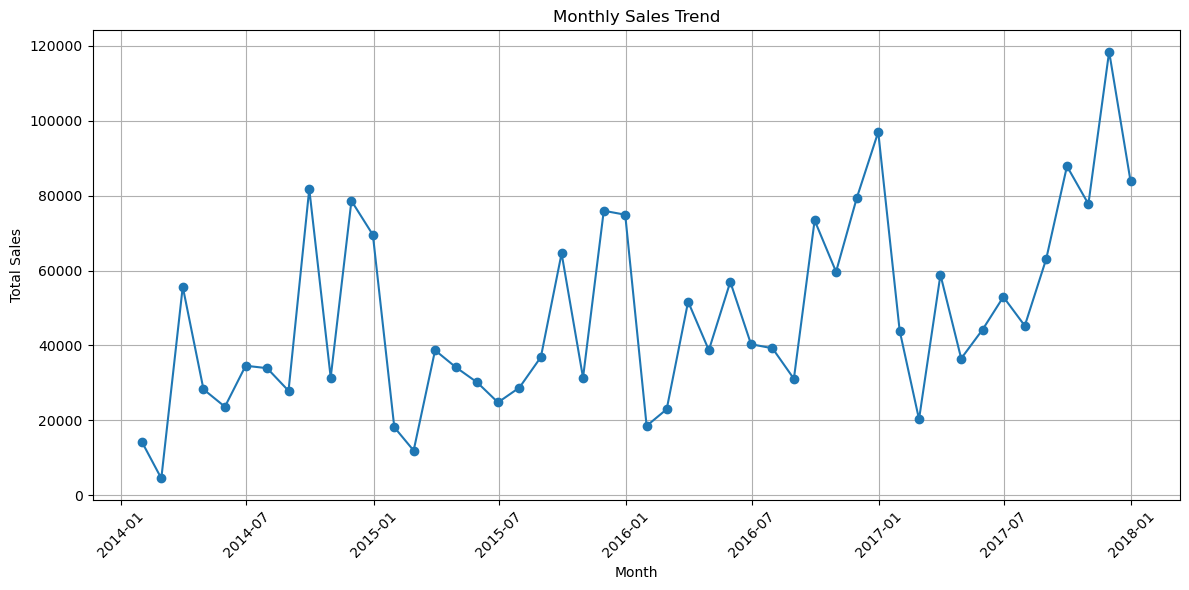

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['order_date'], monthly_sales['sales'], marker='o')

plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()
